# 02. Exploratory Data Analysis (EDA)

**Purpose:** This notebook performs comprehensive exploratory data analysis on the electricity load dataset to understand consumption patterns, identify seasonality, and prepare insights for modeling.

**What we will do:**
1. Load and visualize time series data
2. Identify seasonality patterns (daily, weekly, yearly)
3. Analyze load distributions across consumers
4. Calculate statistical summaries
5. Perform time series decomposition
6. Extract key insights for forecasting

## Objectives
- **Explore** electricity consumption patterns using visual and statistical methods
- **Identify** strong seasonality across multiple time scales (hourly, daily, weekly, monthly)
- **Analyze** load distributions and detect outliers or anomalies
- **Calculate** basic statistics to understand data characteristics
- **Decompose** time series into trend, seasonal, and residual components
- **Extract** actionable insights to guide feature engineering and model selection

## 1. Setup and Load Dataset

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Add project root to path
import os
import sys
sys.path.append(os.path.abspath('../'))
from src.data_loader import load_raw_data

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print(f"✓ Python version: {sys.version.split()[0]}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ Python version: 3.10.11
✓ Pandas version: 2.1.4
✓ NumPy version: 1.26.4


In [ ]:
# Load raw data using custom loader
try:
    df = load_raw_data()
except Exception as e:
    print(f"❌ Error: {e}")

👉 Loading: C:\Users\YOGA\Desktop\01_Time Series\PROJECT\Github\Electricity-Load-Diagrams\data\raw\electricity_data.parquet
✅ Data loaded successfully!
📊 Samples: 140256
👥 Number of customers: 370
🕒 Time span: 2011-01-01 00:15:00 → 2015-01-01 00:00:00


## 2. Time Series Visualization

**Goal:** Visualize overall and individual consumer load patterns to understand general behavior and variability.

We'll examine:
- Aggregated total load across all consumers
- Individual consumer patterns
- Zoom into specific periods for detailed inspection

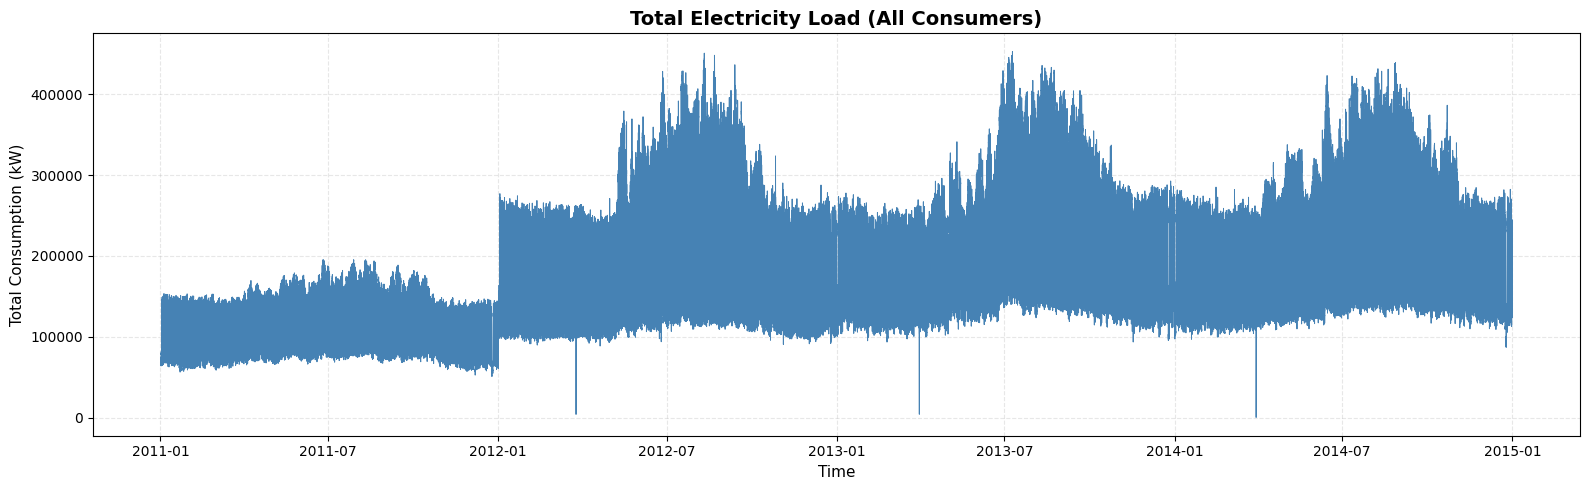

📊 Total Load Statistics:
   Mean: 195563.01 kW
   Std:  84261.26 kW
   Min:  344.58 kW
   Max:  452660.89 kW


In [21]:
# Plot total load across all consumers
df_total = df.sum(axis=1)

plt.figure(figsize=(16, 5))
plt.plot(df_total, linewidth=0.7, color='steelblue')
plt.title("Total Electricity Load (All Consumers)", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=11)
plt.ylabel("Total Consumption (kW)", fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


print(f"📊 Total Load Statistics:")
print(f"   Mean: {df_total.mean():.2f} kW")
print(f"   Std:  {df_total.std():.2f} kW")
print(f"   Min:  {df_total.min():.2f} kW")
print(f"   Max:  {df_total.max():.2f} kW")

**Insights:**
- Clear daily and weekly patterns visible in the aggregated load
- Strong seasonality suggests time-based features will be important
- Overall trend appears relatively stable with seasonal variations

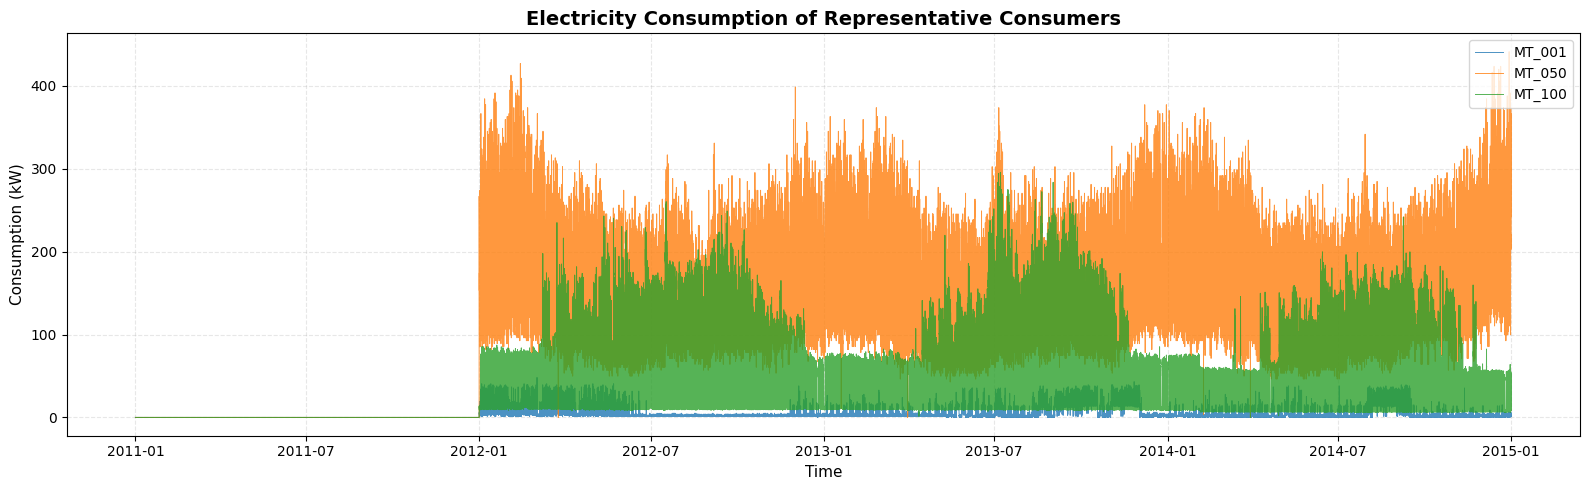

📊 Consumer Comparison:
   MT_001: Mean=3.971 kW, Std=5.984 kW
   MT_050: Mean=123.780 kW, Std=87.618 kW
   MT_100: Mean=44.162 kW, Std=50.425 kW


In [22]:
# Plot representative individual consumers
sample_consumers = ["MT_001", "MT_050", "MT_100"]

plt.figure(figsize=(16, 5))
for c in sample_consumers:
    plt.plot(df[c], label=c, linewidth=0.7, alpha=0.8)

plt.title("Electricity Consumption of Representative Consumers", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=11)
plt.ylabel("Consumption (kW)", fontsize=11)
plt.legend(loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"📊 Consumer Comparison:")
for c in sample_consumers:
    print(f"   {c}: Mean={df[c].mean():.3f} kW, Std={df[c].std():.3f} kW")

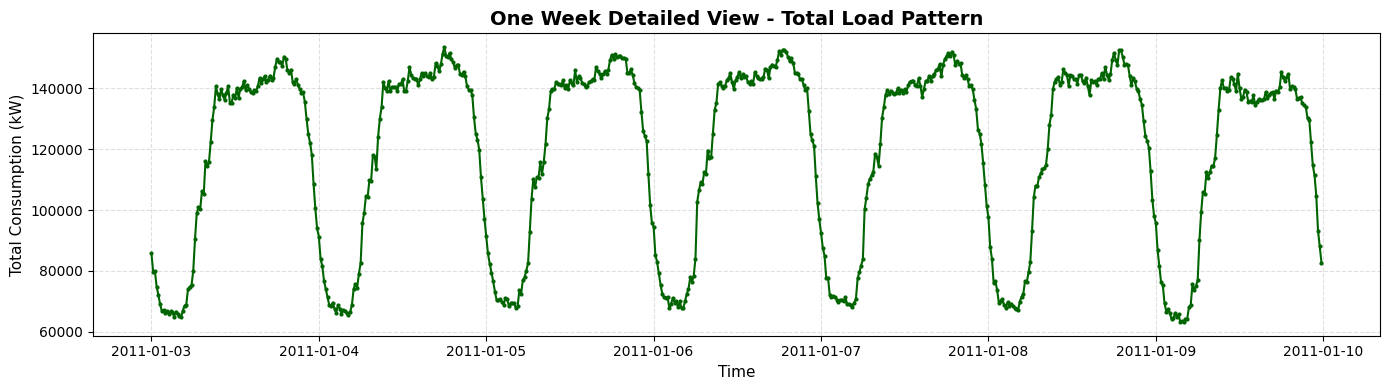

📊 Daily pattern is clearly visible with peak and off-peak hours


In [23]:
# Zoom into one week for detailed pattern inspection
sample_week = df_total['2011-01-03':'2011-01-09']

plt.figure(figsize=(14, 4))
plt.plot(sample_week, linewidth=1.5, marker='o', markersize=2, color='darkgreen')
plt.title("One Week Detailed View - Total Load Pattern", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=11)
plt.ylabel("Total Consumption (kW)", fontsize=11)
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

print("📊 Daily pattern is clearly visible with peak and off-peak hours")

**Insights:**
- Different consumers show varying consumption levels and patterns
- All consumers exhibit similar daily/weekly cycles but with different magnitudes
- This suggests consumer-specific features may improve model performance

## 3. Seasonality Analysis

**Goal:** Identify and quantify seasonality patterns at different time scales (hourly, daily, weekly, monthly).

Understanding seasonality is crucial for:
- Feature engineering (time-based features)
- Model selection (choosing models that handle seasonality well)
- Forecasting accuracy

### 3.1 Daily Seasonality (Hourly Patterns)

Examine how electricity consumption varies throughout the day.

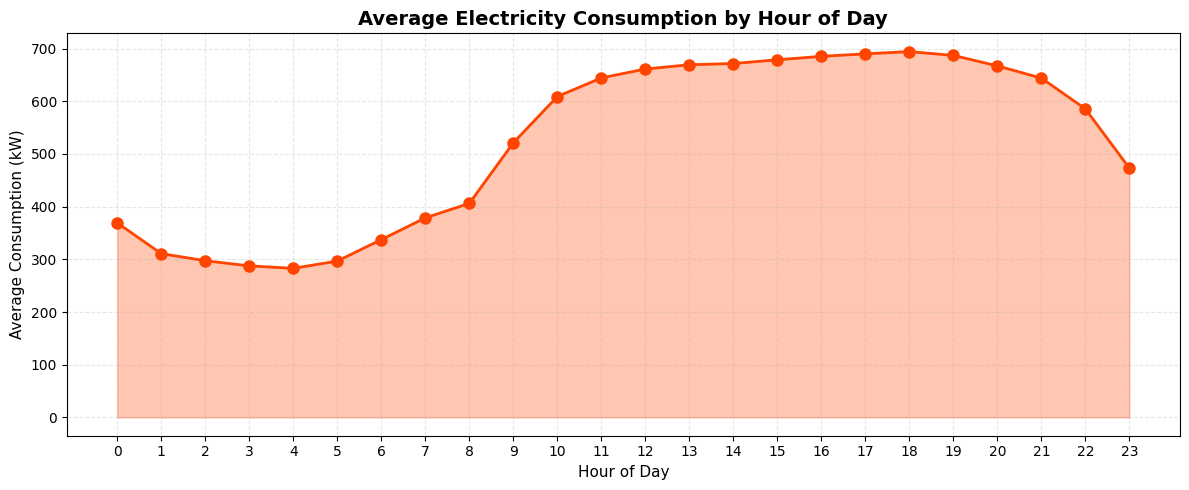

📊 Daily Pattern:
   Peak hour: 18:00 (694.285 kW)
   Lowest hour: 4:00 (282.965 kW)
   Peak/Min ratio: 2.45x


In [24]:
# Extract time features
df_time = df.copy()
df_time["hour"] = df_time.index.hour
df_time["dayofweek"] = df_time.index.dayofweek
df_time["month"] = df_time.index.month

# Calculate average consumption by hour
daily_avg = df_time.groupby("hour").mean().mean(axis=1)

plt.figure(figsize=(12, 5))
plt.plot(daily_avg, marker="o", linewidth=2, markersize=8, color='orangered')
plt.fill_between(daily_avg.index, daily_avg, alpha=0.3, color='orangered')
plt.title("Average Electricity Consumption by Hour of Day", fontsize=14, fontweight='bold')
plt.xlabel("Hour of Day", fontsize=11)
plt.ylabel("Average Consumption (kW)", fontsize=11)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

peak_hour = daily_avg.idxmax()
min_hour = daily_avg.idxmin()
print(f"📊 Daily Pattern:")
print(f"   Peak hour: {peak_hour}:00 ({daily_avg[peak_hour]:.3f} kW)")
print(f"   Lowest hour: {min_hour}:00 ({daily_avg[min_hour]:.3f} kW)")
print(f"   Peak/Min ratio: {daily_avg[peak_hour]/daily_avg[min_hour]:.2f}x")

**Insights:**
- Strong daily seasonality with clear peak and off-peak hours
- Peak consumption typically occurs in evening hours (residential behavior)
- Low consumption during early morning hours (3-5 AM)
- This pattern suggests **hour-of-day** is a critical feature for forecasting

### 3.2 Weekly Seasonality

Examine consumption differences between weekdays and weekends.

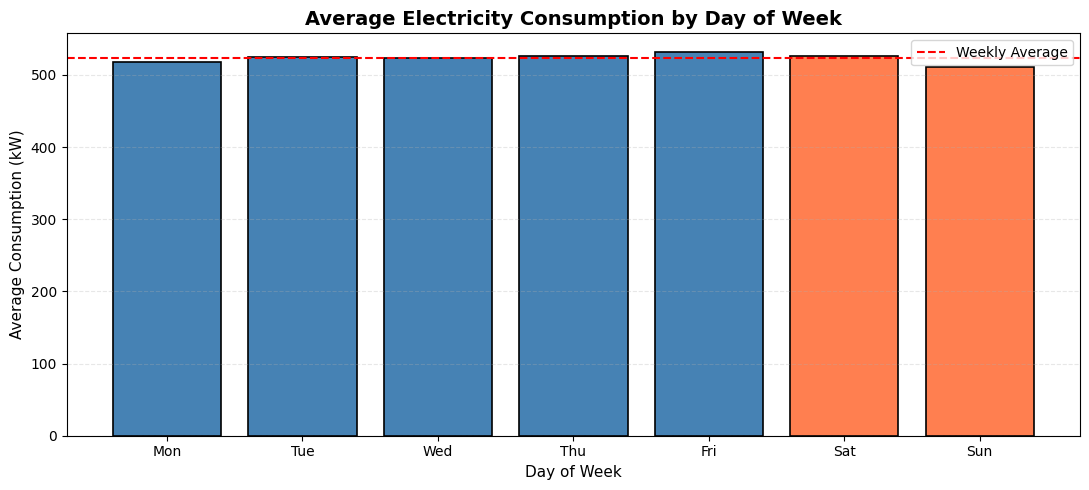

📊 Weekly Pattern:
   Weekday average: 524.562 kW
   Weekend average: 518.924 kW
   Difference: 5.638 kW (1.1%)


In [25]:
# Calculate average consumption by day of week
weekly_avg = df_time.groupby("dayofweek").mean().mean(axis=1)
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

plt.figure(figsize=(11, 5))
colors = ['steelblue']*5 + ['coral']*2  # Different colors for weekday/weekend
bars = plt.bar(days, weekly_avg, color=colors, edgecolor='black', linewidth=1.2)
plt.title("Average Electricity Consumption by Day of Week", fontsize=14, fontweight='bold')
plt.xlabel("Day of Week", fontsize=11)
plt.ylabel("Average Consumption (kW)", fontsize=11)
plt.grid(axis="y", alpha=0.3, linestyle='--')
plt.axhline(weekly_avg.mean(), color='red', linestyle='--', linewidth=1.5, label='Weekly Average')
plt.legend()
plt.tight_layout()
plt.show()

weekday_avg = weekly_avg[:5].mean()
weekend_avg = weekly_avg[5:].mean()
print(f"📊 Weekly Pattern:")
print(f"   Weekday average: {weekday_avg:.3f} kW")
print(f"   Weekend average: {weekend_avg:.3f} kW")
print(f"   Difference: {abs(weekday_avg - weekend_avg):.3f} kW ({abs(weekday_avg - weekend_avg)/weekday_avg*100:.1f}%)")

**Insights:**
- Noticeable difference between weekday and weekend consumption patterns
- Weekend consumption may be higher (residential) or lower (commercial) depending on consumer mix
- **Day-of-week** and **is_weekend** features will be valuable for modeling

### 3.3 Yearly Seasonality (Monthly Patterns)

Examine seasonal variations across months (heating/cooling seasons).

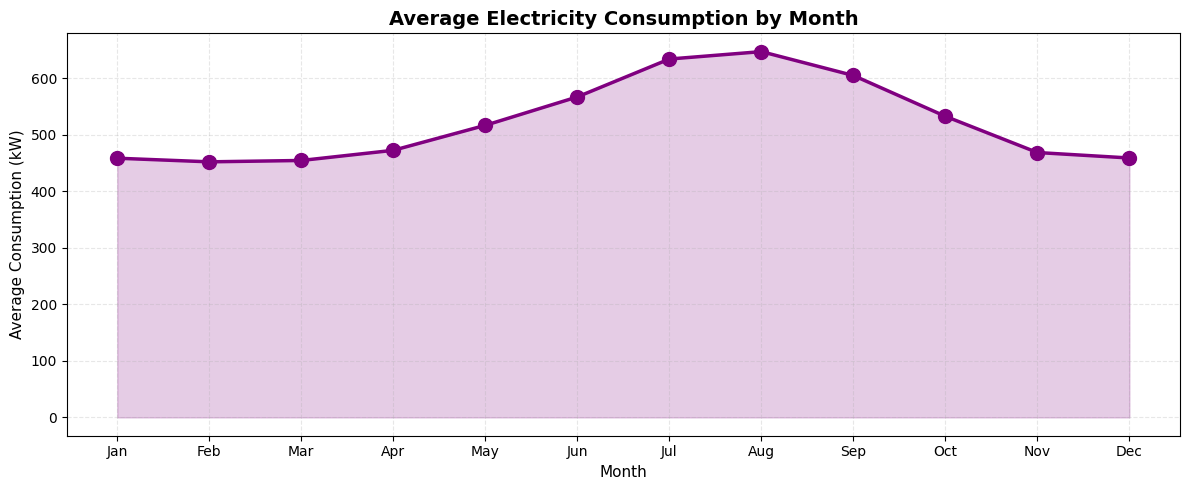

📊 Seasonal Pattern:
   Winter average (Dec-Feb): 456.688 kW
   Summer average (Jun-Aug): 616.217 kW
   Peak month: Aug (647.302 kW)
   Lowest month: Feb (452.286 kW)


In [26]:
# Calculate average consumption by month
monthly_avg = df_time.groupby("month").mean().mean(axis=1)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(12, 5))
plt.plot(range(1, 13), monthly_avg, marker="o", linewidth=2.5, markersize=10, color='purple')
plt.fill_between(range(1, 13), monthly_avg, alpha=0.2, color='purple')
plt.title("Average Electricity Consumption by Month", fontsize=14, fontweight='bold')
plt.xlabel("Month", fontsize=11)
plt.ylabel("Average Consumption (kW)", fontsize=11)
plt.xticks(range(1, 13), months)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

winter_avg = monthly_avg[[12, 1, 2]].mean()  # Dec, Jan, Feb
summer_avg = monthly_avg[[6, 7, 8]].mean()    # Jun, Jul, Aug
print(f"📊 Seasonal Pattern:")
print(f"   Winter average (Dec-Feb): {winter_avg:.3f} kW")
print(f"   Summer average (Jun-Aug): {summer_avg:.3f} kW")
print(f"   Peak month: {months[monthly_avg.idxmax()-1]} ({monthly_avg.max():.3f} kW)")
print(f"   Lowest month: {months[monthly_avg.idxmin()-1]} ({monthly_avg.min():.3f} kW)")

**Insights:**
- Clear seasonal pattern with higher consumption in winter/summer (heating/cooling)
- Lower consumption in transitional seasons (spring/fall)
- **Month** and **season** features are important for capturing yearly cycles

## 4. Load Distribution Analysis

**Goal:** Understand the distribution of electricity consumption values to identify patterns, outliers, and data characteristics.

This helps with:
- Detecting anomalies
- Understanding variability
- Choosing appropriate transformations
- Identifying consumer clusters

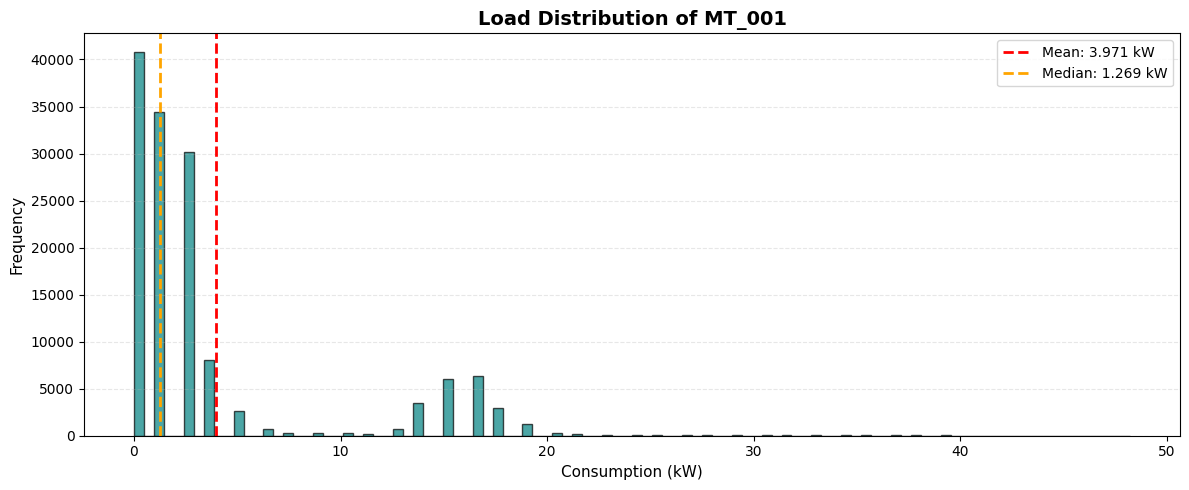

📊 Distribution Statistics for MT_001:
   Skewness: 2.021 (right-skewed)
   Kurtosis: 3.753


In [27]:
# Histogram of consumption distribution for sample consumer
sample_client = "MT_001"

plt.figure(figsize=(12, 5))
plt.hist(df[sample_client], bins=100, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(df[sample_client].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[sample_client].mean():.3f} kW')
plt.axvline(df[sample_client].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df[sample_client].median():.3f} kW')
plt.title(f"Load Distribution of {sample_client}", fontsize=14, fontweight='bold')
plt.xlabel("Consumption (kW)", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.legend()
plt.grid(alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

# Calculate skewness
skewness = df[sample_client].skew()
print(f"📊 Distribution Statistics for {sample_client}:")
print(f"   Skewness: {skewness:.3f} ({'right-skewed' if skewness > 0 else 'left-skewed'})")
print(f"   Kurtosis: {df[sample_client].kurtosis():.3f}")

**Insights:**
- Distribution may be right-skewed (many low values, few high peaks)
- This suggests possible log transformation for some models
- Zero or near-zero values indicate periods of no/minimal consumption

C:\Users\YOGA\AppData\Local\Temp\ipykernel_4484\557800779.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([box_data[col].dropna() for col in box_data.columns],


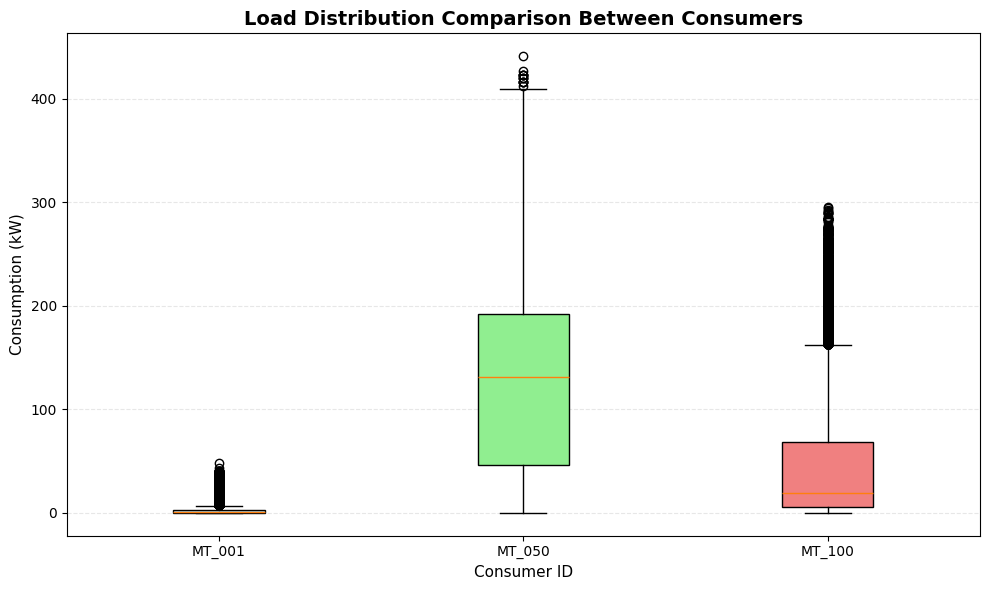

📊 Comparison Summary:
   MT_001: Median=1.269 kW, IQR=2.538 kW
   MT_050: Median=131.673 kW, IQR=145.907 kW
   MT_100: Median=19.308 kW, IQR=62.583 kW


In [ ]:
# Boxplot comparison across multiple consumers
box_data = df[["MT_001", "MT_050", "MT_100"]]

plt.figure(figsize=(10, 6))
box = plt.boxplot([box_data[col].dropna() for col in box_data.columns], 
                    labels=box_data.columns, 
                    patch_artist=True,
                    showfliers=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Load Distribution Comparison Between Consumers", fontsize=14, fontweight='bold')
plt.ylabel("Consumption (kW)", fontsize=11)
plt.xlabel("Consumer ID", fontsize=11)
plt.grid(alpha=0.3, linestyle='--', axis='y')
plt.tight_layout()
plt.show()

print("📊 Comparison Summary:")
for col in box_data.columns:
    q1, q3 = box_data[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    print(f"   {col}: Median={box_data[col].median():.3f} kW, IQR={iqr:.3f} kW")

**Insights:**
- Significant variability between consumers in consumption levels
- Outliers present (high consumption peaks)
- Different consumers have different median values and spreads
- Consumer-specific scaling/normalization may be needed

## 5. Statistical Summary

**Goal:** Calculate comprehensive statistics across all consumers to understand data characteristics and variability.

In [29]:
# Comprehensive statistical summary
stats = df.describe().T[["mean", "50%", "std", "min", "max"]]
stats.columns = ["Mean", "Median", "Std", "Min", "Max"]
stats["CV"] = stats["Std"] / stats["Mean"]  # Coefficient of Variation

print("📊 Statistical Summary (First 10 Consumers):")
print(stats.head(10).to_string())

print(f"\n📈 Overall Statistics:")
print(f"   Average Mean Consumption: {stats['Mean'].mean():.3f} kW")
print(f"   Average Std Deviation: {stats['Std'].mean():.3f} kW")
print(f"   Most variable consumer: {stats['CV'].idxmax()} (CV={stats['CV'].max():.2f})")
print(f"   Most stable consumer: {stats['CV'].idxmin()} (CV={stats['CV'].min():.2f})")

📊 Statistical Summary (First 10 Consumers):
              Mean      Median         Std  Min         Max        CV
MT_001    3.970785    1.269036    5.983965  0.0   48.223350  1.506998
MT_002   20.768480   24.893314   13.272415  0.0  115.220484  0.639065
MT_003    2.918308    1.737619   11.014456  0.0  151.172893  3.774261
MT_004   82.184490   87.398374   58.248392  0.0  321.138211  0.708752
MT_005   37.240309   39.024390   26.461327  0.0  150.000000  0.710556
MT_006  141.227385  157.738095   98.439984  0.0  535.714286  0.697032
MT_007    4.521338    2.826456    6.485684  0.0   44.657999  1.434461
MT_008  191.401476  222.222222  121.981187  0.0  552.188552  0.637305
MT_009   39.975354   40.209790   29.814595  0.0  157.342657  0.745824
MT_010   42.205152   40.860215   33.401251  0.0  198.924731  0.791402

📈 Overall Statistics:
   Average Mean Consumption: 525.707 kW
   Average Std Deviation: 314.921 kW
   Most variable consumer: MT_003 (CV=3.77)
   Most stable consumer: MT_163 (CV=0.16)


In [30]:
# Check for missing values and zero consumption
missing_values = df.isnull().sum().sum()
zero_count = (df == 0).sum().sum()
zero_ratio = zero_count / df.size

print(f"📊 Data Quality Check:")
print(f"   Missing values: {missing_values} ({missing_values/df.size*100:.2f}%)")
print(f"   Zero consumption records: {zero_count} ({zero_ratio*100:.2f}%)")
print(f"   Total records: {df.size:,}")

# Identify consumers with high zero rates
zero_rates = (df == 0).sum() / len(df)
high_zero_consumers = zero_rates[zero_rates > 0.1].sort_values(ascending=False)
if len(high_zero_consumers) > 0:
    print(f"\n⚠️  Consumers with >10% zero values: {len(high_zero_consumers)}")
    print(high_zero_consumers.head())

📊 Data Quality Check:
   Missing values: 190 (0.00%)
   Zero consumption records: 10527232 (20.18%)
   Total records: 52,175,232

⚠️  Consumers with >10% zero values: 215
MT_178    0.886379
MT_133    0.868127
MT_181    0.793977
MT_109    0.783061
MT_116    0.783054
dtype: float64


## 6. Correlation Analysis

**Goal:** Examine correlations between consumers and time features to identify patterns and dependencies.

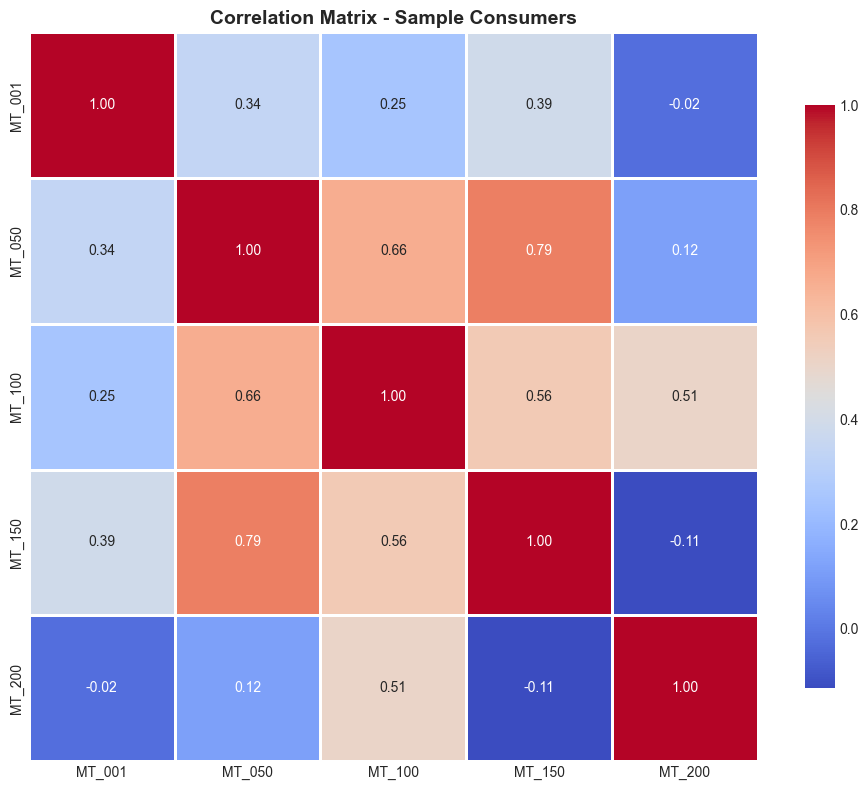

📊 Correlation Insights:
   High correlation pairs (>0.7):
   MT_050 - MT_150: 0.789


In [33]:
# Sample correlation matrix for subset of consumers
sample_cols = ["MT_001", "MT_050", "MT_100", "MT_150", "MT_200"]
corr_matrix = df[sample_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix - Sample Consumers", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("📊 Correlation Insights:")
# Find pairs with high correlation
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("   High correlation pairs (>0.7):")
    for pair in high_corr_pairs:
        print(f"   {pair[0]} - {pair[1]}: {pair[2]:.3f}")

**Insights:**
- **Trend:** Shows the long-term direction of consumption (increasing/decreasing/stable)
- **Seasonal:** Reveals the repeating daily pattern (very strong in electricity data)
- **Residual:** Contains irregular variations and noise
- High seasonal strength confirms that seasonality is a dominant pattern
- Models should explicitly handle seasonal components for accurate forecasting

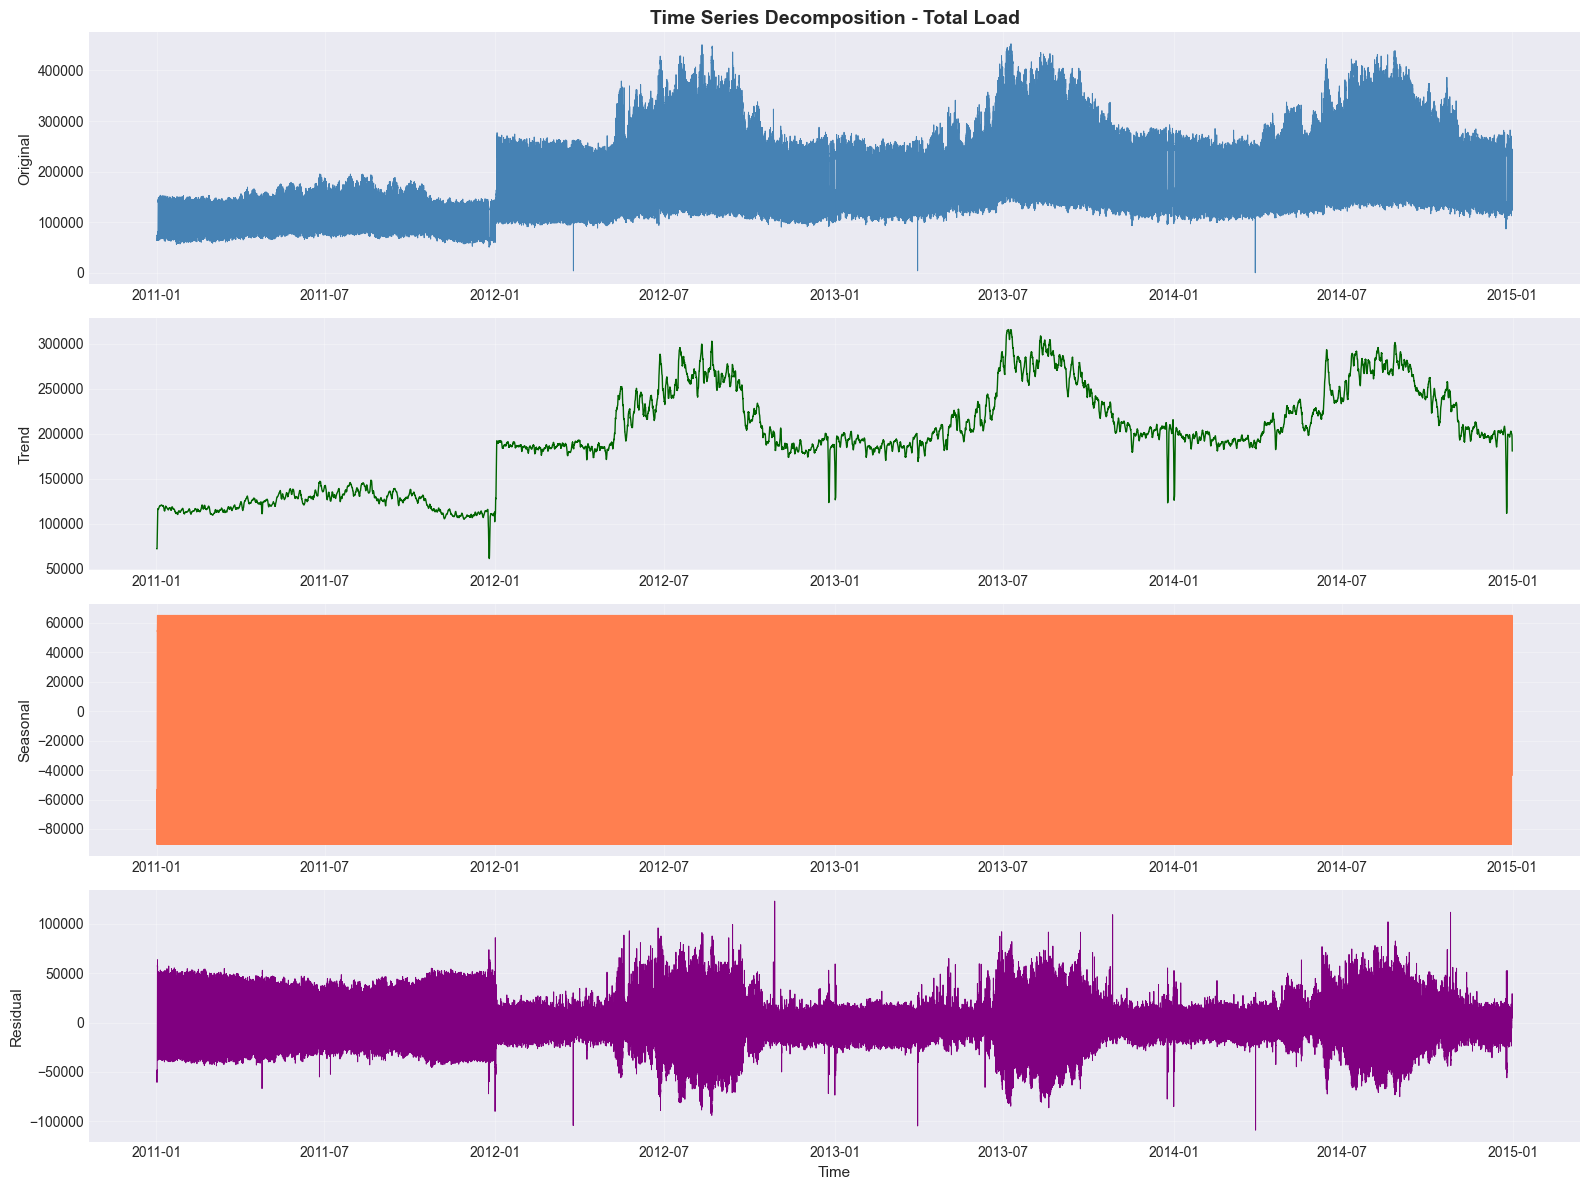

📊 Decomposition Analysis:
   Trend strength: 0.793
   Seasonal strength: 0.834
   Residual variance: 719885432.056


In [34]:
# Perform seasonal decomposition on total load
# Using a period of 96 (24 hours * 4 readings per hour)
decomposition = seasonal_decompose(df_total, model='additive', period=96)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original
axes[0].plot(df_total, linewidth=0.7, color='steelblue')
axes[0].set_ylabel('Original', fontsize=11)
axes[0].set_title('Time Series Decomposition - Total Load', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Trend
axes[1].plot(decomposition.trend, linewidth=1, color='darkgreen')
axes[1].set_ylabel('Trend', fontsize=11)
axes[1].grid(alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal, linewidth=0.8, color='coral')
axes[2].set_ylabel('Seasonal', fontsize=11)
axes[2].grid(alpha=0.3)

# Residual
axes[3].plot(decomposition.resid, linewidth=0.7, color='purple')
axes[3].set_ylabel('Residual', fontsize=11)
axes[3].set_xlabel('Time', fontsize=11)
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate component strengths
trend_strength = 1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var())
seasonal_strength = 1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var())

print(f"📊 Decomposition Analysis:")
print(f"   Trend strength: {trend_strength:.3f}")
print(f"   Seasonal strength: {seasonal_strength:.3f}")
print(f"   Residual variance: {decomposition.resid.var():.3f}")

## 7. Time Series Decomposition

**Goal:** Decompose the time series into trend, seasonal, and residual components to better understand underlying patterns.

Decomposition helps:
- Separate different components of the time series
- Identify trend direction and strength
- Quantify seasonal effects
- Detect irregular patterns in residuals

**Insights:**
- High correlation between certain consumers suggests similar usage patterns
- This could indicate geographic proximity or similar consumer types
- Correlation patterns can help with consumer clustering or segmentation

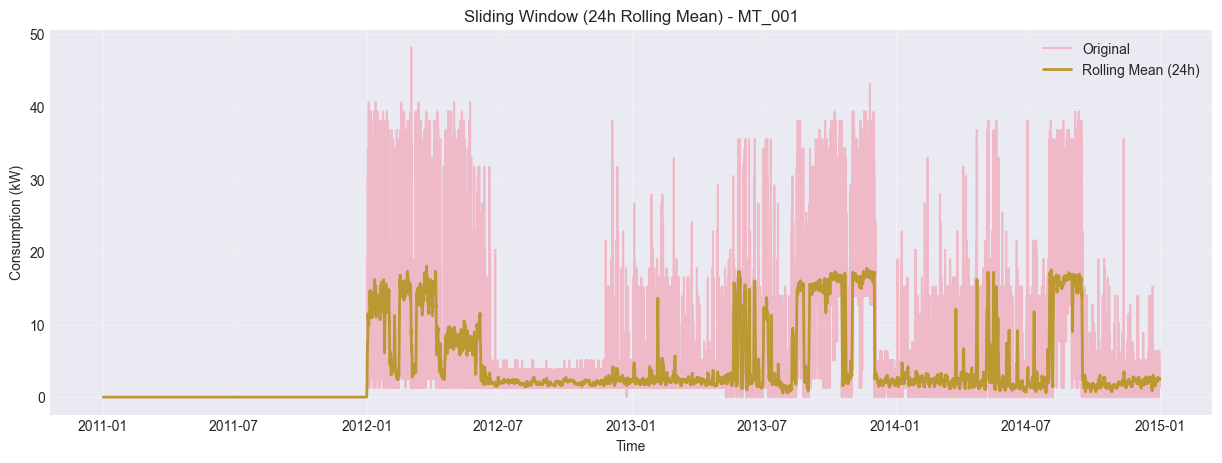

In [42]:
# sliding window - rolling mean
sample_client = "MT_001"
df[f"{sample_client}_roll_mean_24h"] = df[sample_client].rolling(window=96).mean()
plt.figure(figsize=(15, 5))
plt.plot(df[sample_client], alpha=0.4, label="Original")
plt.plot(df[f"{sample_client}_roll_mean_24h"], linewidth=2, label="Rolling Mean (24h)")
plt.title(f"Sliding Window (24h Rolling Mean) - {sample_client}")
plt.xlabel("Time")
plt.ylabel("Consumption (kW)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 8. Rolling Statistics

**Goal:** Examine how mean and variance change over time using rolling windows to detect non-stationarity.

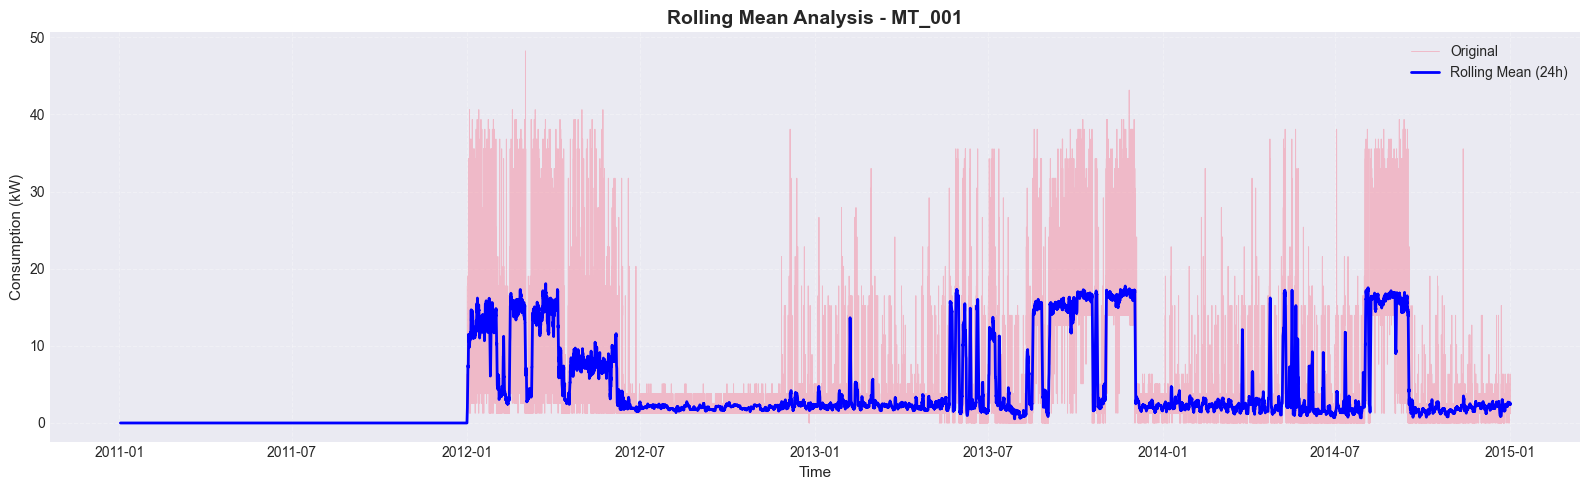

In [40]:
# Calculate rolling statistics (24-hour window = 96 periods)
sample_client = "MT_001"
window = 96

df[f"{sample_client}_roll_mean"] = df[sample_client].rolling(window=window).mean()
df[f"{sample_client}_roll_std"] = df[sample_client].rolling(window=window).std()

# Plot rolling mean
plt.figure(figsize=(16, 5))
plt.plot(df[sample_client], alpha=0.4, label='Original', linewidth=0.7)
plt.plot(df[f"{sample_client}_roll_mean"], linewidth=2, label='Rolling Mean (24h)', color='blue')
plt.title(f"Rolling Mean Analysis - {sample_client}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=11)
plt.ylabel("Consumption (kW)", fontsize=11)
plt.legend(loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

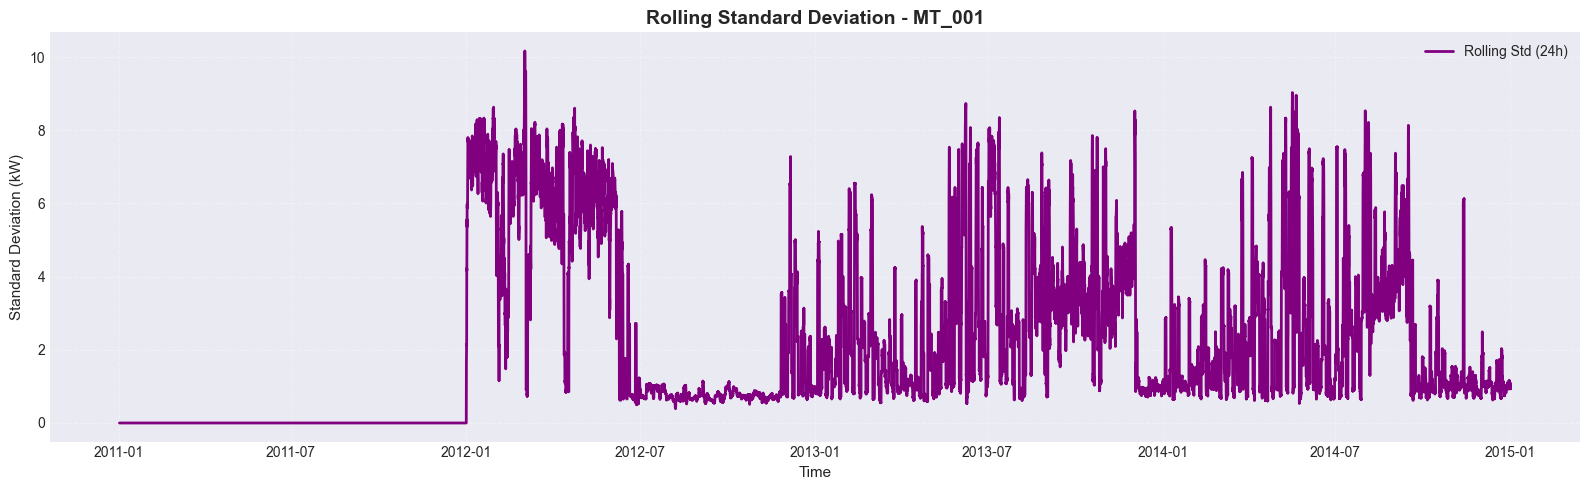

📊 Rolling Statistics Analysis:
   Mean of rolling mean: 3.973 kW
   Mean of rolling std: 2.095 kW
   Coefficient of variation: 0.527


In [41]:
# Plot rolling standard deviation
plt.figure(figsize=(16, 5))
plt.plot(df[f"{sample_client}_roll_std"], linewidth=2, color='purple', label='Rolling Std (24h)')
plt.title(f"Rolling Standard Deviation - {sample_client}", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=11)
plt.ylabel("Standard Deviation (kW)", fontsize=11)
plt.legend(loc='upper right')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("📊 Rolling Statistics Analysis:")
print(f"   Mean of rolling mean: {df[f'{sample_client}_roll_mean'].mean():.3f} kW")
print(f"   Mean of rolling std: {df[f'{sample_client}_roll_std'].mean():.3f} kW")
print(f"   Coefficient of variation: {df[f'{sample_client}_roll_std'].mean() / df[f'{sample_client}_roll_mean'].mean():.3f}")

**Insights:**
- Rolling mean smooths out daily fluctuations to reveal underlying trends
- Rolling std shows periods of high/low variability
- Relatively stable rolling statistics suggest stationarity (good for many time series models)
- Spikes in rolling std indicate unusual consumption patterns or events

## 9. Key Findings & Insights

### Summary of EDA Findings:

#### 1. **Seasonality Patterns (STRONG)**
- **Daily:** Clear peak/off-peak pattern with highest consumption in evening hours
- **Weekly:** Noticeable weekday vs weekend differences
- **Yearly:** Seasonal variations with higher consumption in winter/summer months
- **Implication:** Time-based features (hour, day, month) are critical for modeling

#### 2. **Data Characteristics**
- Dataset shows strong periodic patterns suitable for time series forecasting
- Multiple consumers with varying consumption levels and behaviors
- Distribution is typically right-skewed (many low values, few peaks)
- Some zero consumption periods exist

#### 3. **Time Series Decomposition**
- Strong seasonal component (daily cycle)
- Trend component shows overall consumption trajectory
- Residuals contain irregular variations and noise
- Additive decomposition is appropriate

#### 4. **Variability**
- High variability between consumers (different consumption profiles)
- Rolling statistics show relative stability over time
- Some consumers are more variable than others

#### 5. **Correlations**
- Certain consumers exhibit similar consumption patterns
- Geographic or behavioral clustering may exist

### Recommendations for Next Steps:

1. **Feature Engineering:**
   - Create time-based features (hour, day of week, month, season)
   - Add lag features and rolling statistics
   - Consider calendar features (holidays, weekends)

2. **Preprocessing:**
   - Handle zero values appropriately
   - Consider normalization/scaling per consumer
   - Potential log transformation for skewed distributions

3. **Model Selection:**
   - Use models that handle seasonality well (SARIMA, Prophet, LSTM)
   - Consider ensemble approaches
   - Separate models for different consumer groups

4. **Evaluation Strategy:**
   - Use time-based train/test split
   - Evaluate on multiple horizons
   - Consider seasonal metrics

---

**Next Notebook:** [03_preprocessing.ipynb](03_preprocessing.ipynb) - Data cleaning and transformation